#### Required imports

In [19]:
# Imports

import hypernetx as hnx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import warnings
import re


warnings.simplefilter('ignore')

from sympy import *
import sympy

init_printing()

## Both the class for finding each individual modules properties and the class for combining two modules together

In [ ]:
class ModuleProperties:
    """
    Encapsulates a reaction module and provides methods to compute:
      - reaction cycles (kernel of internal SM)
      - coupling matrix (external_SM * cycle_matrix)
      - conservation laws (cokernel of full SM and coupling matrix)
      - reaction resistance matrices and conductances
      - physical currents and hypergraph drawing helpers

    Public attributes (kept for compatibility with original code):
      - matrix, internal_SM, external_SM, hypergraph_labels, num_internal_species
      - chemical_potentials_vector, force_vector, edge_currents_vector
      - kinetic_form_resistance_matrix
    """

    def __init__(self, SM: Matrix, num_internal_species: int, hypergraph_labels: dict, species_names: list):
        # store basic matrices and labels
        self.matrix = SM
        self.num_internal_species = num_internal_species
        self.internal_SM = SM[0:num_internal_species, :]
        self.external_SM = SM[num_internal_species: len(SM), :]
        self.hypergraph_labels = hypergraph_labels

        # build labels and symbolic vectors (chemical potentials, edge currents)
        self._label_species_and_potentials(species_names)
        self._label_reactions_and_forces()

        # keep placeholders for lazily computed objects
        self.cycle_matrix = None
        self.phi = None
        self.T_cons_laws = None
        self.T_chemostat_laws = None
        self.resistance_matrix = None
        self.cycle_resistance_matrix = None
        self.physical_conductance_matrix = None

    # -------------------------
    # Label helpers
    # -------------------------
    def _label_species_and_potentials(self, species_names: list):
        """Create symbolic chemical potentials vector from species_names."""
        self.chemical_potentials = []
        num_rows = self.matrix.rows
        for n in range(num_rows):
            species_symbol = symbols(species_names[n])
            chem_pot = symbols(f"\mu_{species_symbol}")
            self.chemical_potentials.append(chem_pot)
        self.chemical_potentials_vector = Matrix(self.chemical_potentials).T

    def _label_reactions_and_build_forces(self):
        """(Deprecated) kept for compatibility if needed externally."""
        return self._label_reactions_and_forces()

    def _label_reactions_and_forces(self):
        """Create symbolic reaction resistances, edge currents and reaction-level forces."""
        num_cols = self.matrix.cols
        resistances = []
        edge_currents_j = []
        forces = []

        for n in range(num_cols):
            nth_resistance = symbols(f"r{n+1}")
            resistances.append(nth_resistance)

            nth_edge_currents_j = symbols(f"j{n+1}")
            edge_currents_j.append(nth_edge_currents_j)

            reaction_vector = -1 * self.matrix[:, n]
            # force = chemical potentials vector * reaction vector (keeps original sign convention)
            forces.append(self.chemical_potentials_vector * reaction_vector)

        self.force_vector = Matrix(forces)
        self.edge_currents_vector = Matrix(edge_currents_j)

        # reaction-level resistance in kinetic form r = f / j (symbolic)
        reaction_level_res = []
        for n in range(num_cols):
            symbolic_resistance = self.force_vector[n] / self.edge_currents_vector[n]
            reaction_level_res.append(symbolic_resistance)

        self.kinetic_form_resistance_matrix = Matrix.diag(reaction_level_res)

    # -------------------------
    # Hypergraph helpers
    # -------------------------
    def hypergraph_internals(self):
        """Draw hypergraph for internal species (requires hnx)."""
        internals_HG = hnx.Hypergraph.from_incidence_matrix(self.internal_SM)
        hnx.draw(internals_HG, node_labels=self.hypergraph_labels, with_edge_labels=True)

    def hypergraph_full(self):
        """Draw hypergraph for full stoichiometric matrix (requires hnx)."""
        full_HG = hnx.Hypergraph.from_incidence_matrix(self.matrix)
        hnx.draw(full_HG, node_labels=self.hypergraph_labels, with_edge_labels=True)

    # -------------------------
    # Reaction cycles and coupling
    # -------------------------
    def calculate_reaction_cycles_matrix(self) -> Matrix:
        """
        Compute and cache the reaction-level cycle matrix (kernel of internal_SM).
        Returns the cycle matrix (columns are kernel vectors).
        """
        if self.cycle_matrix is not None:
            return self.cycle_matrix

        reaction_cycles = self.internal_SM.nullspace()
        if not reaction_cycles:
            # keep cycle_matrix as empty Matrix for downstream checks
            self.cycle_matrix = Matrix([])
            print("No internal cycles. Kernel is empty.")
            return self.cycle_matrix

        # join kernel vectors column-wise
        cycle_matrix = reaction_cycles[0]
        for cycle in reaction_cycles[1:]:
            cycle_matrix = cycle_matrix.row_join(cycle)

        self.cycle_matrix = cycle_matrix
        return cycle_matrix

    def calculate_coupling_matrix(self) -> Matrix:
        """Compute and cache coupling matrix phi = external_SM * cycle_matrix."""
        if self.phi is not None:
            return self.phi

        cycle_matrix = self.calculate_reaction_cycles_matrix()
        if cycle_matrix == Matrix([]):
            self.phi = Matrix([])
            return self.phi

        phi = self.external_SM * cycle_matrix
        self.phi = phi
        return phi

    # -------------------------
    # Conservation laws
    # -------------------------
    def calculate_conservation_laws(self):
        """
        Compute conservation laws for the full stoichiometric matrix (cokernel of matrix.T)
        and chemostat conservation laws (cokernel of coupling_matrix.T).
        Returns (cons_laws.T, chemostat_laws.T) to match original API.
        """
        # full SM cokernel
        cokernel_SM = (self.matrix.T).nullspace()
        if not cokernel_SM:
            print("No conservation laws. Cokernel of Stoichiometric Matrix empty.")
            cons_laws = Matrix([])
        else:
            cons_laws = cokernel_SM[0]
            for vec in cokernel_SM[1:]:
                cons_laws = cons_laws.row_join(vec)

        # chemostat (broken external) laws from coupling matrix
        coupling_matrix = self.calculate_coupling_matrix()
        if coupling_matrix == Matrix([]):
            chemostat_laws = Matrix([])
            print("No chemostat conservation laws. Coupling matrix empty.")
        else:
            cokernel_coupling_matrix = coupling_matrix.T.nullspace()
            if not cokernel_coupling_matrix:
                chemostat_laws = Matrix([])
                print("No chemostat conservation laws. Cokernel of Coupling Matrix is empty.")
            else:
                chemostat_laws = cokernel_coupling_matrix[0]
                for law in cokernel_coupling_matrix[1:]:
                    chemostat_laws = chemostat_laws.row_join(law)

        # cache transposes (kept names similar to original)
        self.T_cons_laws = cons_laws.T if cons_laws != Matrix([]) else Matrix([])
        self.T_chemostat_laws = chemostat_laws.T if chemostat_laws != Matrix([]) else Matrix([])

        return self.T_cons_laws, self.T_chemostat_laws

    # -------------------------
    # Reaction resistance and cycle resistance
    # -------------------------
    def calculate_reaction_resistance_matrix(self) -> Matrix:
        """
        Build a diagonal symbolic reaction resistance matrix r1, r2, ... and cache it.
        Returns the diagonal resistance matrix.
        """
        if self.resistance_matrix is not None:
            return self.resistance_matrix

        num_cols = self.matrix.cols
        resistances = []
        for n in range(num_cols):
            nth_reaction = symbols(f"r{n+1}")
            resistances.append(nth_reaction)

        resistance_matrix = Matrix.diag(resistances)
        self.resistance_matrix = resistance_matrix
        return resistance_matrix

    def calculate_cycle_resistance_matrix(self) -> Matrix:
        """Compute cycle resistance matrix: C^T * R * C (where C is cycle_matrix)."""
        if self.cycle_resistance_matrix is not None:
            return self.cycle_resistance_matrix

        C = self.calculate_reaction_cycles_matrix()
        if C == Matrix([]):
            self.cycle_resistance_matrix = Matrix([])
            return self.cycle_resistance_matrix

        R = self.calculate_reaction_resistance_matrix()
        cycle_resistance_matrix = C.T * R * C
        self.cycle_resistance_matrix = cycle_resistance_matrix
        return cycle_resistance_matrix

    # -------------------------
    # Conductance and currents
    # -------------------------
    def calculate_physical_conductance_matrix(self) -> Matrix:
        """
        Compute physical conductance: phi * (C^T R C)^{-1} * phi^T.
        Returns the physical conductance matrix.
        """
        if self.physical_conductance_matrix is not None:
            return self.physical_conductance_matrix

        phi = self.calculate_coupling_matrix()
        cycle_R = self.calculate_cycle_resistance_matrix()
        if phi == Matrix([]) or cycle_R == Matrix([]):
            self.physical_conductance_matrix = Matrix([])
            return self.physical_conductance_matrix

        physical_conductance_matrix = phi * cycle_R.inv() * phi.T
        self.physical_conductance_matrix = physical_conductance_matrix
        return physical_conductance_matrix

    def calculate_physical_currents(self) -> Matrix:
        """
        Solve internal_SM * j = 0 for edge currents j and return external currents:
          currents = - external_SM * j (with substitution of solved j).
        This preserves the original approach.
        """
        # solve for edge currents j
        currents_constraints = sympy.solve(self.internal_SM * self.edge_currents_vector, self.edge_currents_vector)
        currents = (-1 * self.external_SM * self.edge_currents_vector).subs(currents_constraints)
        return currents

    # compatibility helper
    def labels(self):
        return self.hypergraph_labels

    def __add__(self, other):
        something =  CombiningModules(self, other)
        return ModuleProperties.extra_constructor(something)

# -------------------------------------------------------------------------
# CombiningModules
# -------------------------------------------------------------------------
class CombiningModules:
    """
    Combine two ModuleProperties-like objects (mod1, mod2) into a combined module.
    """

    def __init__(self, mod1: ModuleProperties, mod2: ModuleProperties):
        # store modules
        self.mod1 = mod1
        self.mod2 = mod2

        # orchestrates the sequence of computations using broken down methods
        self._find_matching_species()
        self._compute_initial_partitioned_currents()
        self._solve_constraints_and_substitute()
        self._split_currents_after_substitution()
        self._compute_chemostat_conservation_laws()
        self._compute_selection_matrices()
        self._compute_pi_and_PI()
        self._compute_conductances_and_relabel()
        self._assemble_mod3_resistance()

    # -------------------------
    # Step 1 Find matching external species
    # -------------------------
    def _find_matching_species(self):
        """
        Find indices of matching external species between mod1 and mod2.
        """
        self.mod1_external_species_list = {
            i: v for i, v in enumerate(list(self.mod1.labels().values())[self.mod1.internal_SM.rows:])
        }
        self.mod2_external_species_list = {
            i: v for i, v in enumerate(list(self.mod2.labels().values())[self.mod2.internal_SM.rows:])
        }

        self.matching_species = []
        for key1, value1 in self.mod1_external_species_list.items():
            for key2, value2 in self.mod2_external_species_list.items():
                if value1 == value2:
                    self.matching_species.append((key1, key2))

        if self.matching_species:
            self.keys_1, self.keys_2 = zip(*self.matching_species)
            self.keys_1 = list(self.keys_1)
            self.keys_2 = list(self.keys_2)
        else:
            self.keys_1, self.keys_2 = [], []

    # -------------------------
    # Step 2 Compute currents partitions (before solving constraints)
    # -------------------------
    def _compute_initial_partitioned_currents(self):
        """
        Compute the right/left partitions of currents using each module's calculate_physical_currents() method.
        """
        # compute raw currents for each module
        self.mod1_raw_currents = self.mod1.calculate_physical_currents()
        self.mod2_raw_currents = self.mod2.calculate_physical_currents()

        # partition into matched and unmatched (left/right) parts
        self.mod1_right_current = sympy.Matrix([self.mod1_raw_currents[i] for i in self.keys_1]) if self.keys_1 else sympy.Matrix([])
        self.mod2_left_current = sympy.Matrix([self.mod2_raw_currents[i] for i in self.keys_2]) if self.keys_2 else sympy.Matrix([])

        self.mod1_left_current = sympy.Matrix([self.mod1_raw_currents[i] for i in range(self.mod1.external_SM.rows) if i not in self.keys_1])
        self.mod2_right_current = sympy.Matrix([self.mod2_raw_currents[i] for i in range(self.mod2.external_SM.rows) if i not in self.keys_2])

    # -------------------------
    # Step 3 Solve constraints and substitute
    # -------------------------
    def _solve_constraints_and_substitute(self):
        """
        Build constraint equations that matching currents sum to zero,
        solve for free symbols from mod1_right_current, and substitute solutions.
        """
        constraint_eqs = []
        for i in range(len(self.mod1_right_current)):
            constraint_eqs.append(self.mod1_right_current[i] + self.mod2_left_current[i])

        # choose symbols from mod1_right_current to solve for (original code used free_symbols)
        symbols_mod1 = self.mod1_right_current.free_symbols

        # solve constraints (original behaviour)
        self.constraints = sympy.solve(constraint_eqs, symbols_mod1)

        # substitute constraints into original currents
        self.mod1_current = self.mod1.calculate_physical_currents().subs(self.constraints)
        self.mod2_current = self.mod2.calculate_physical_currents().subs(self.constraints)

    # -------------------------
    # Step 4 Split currents after substitution
    # -------------------------
    def _split_currents_after_substitution(self):
        """Recompute left/right partitions after substitution and build mod3_current."""
        self.mod1_right_current = sympy.Matrix([self.mod1_current[i] for i in self.keys_1]) if self.keys_1 else sympy.Matrix([])
        self.mod2_left_current = sympy.Matrix([self.mod2_current[i] for i in self.keys_2]) if self.keys_2 else sympy.Matrix([])

        self.mod1_left_current = sympy.Matrix([self.mod1_current[i] for i in range(self.mod1.external_SM.rows) if i not in self.keys_1])
        self.mod2_right_current = sympy.Matrix([self.mod2_current[i] for i in range(self.mod2.external_SM.rows) if i not in self.keys_2])

        # stacked external currents for the combined module
        self.mod3_current = sympy.Matrix.vstack(self.mod1_left_current, self.mod2_right_current)

    # -------------------------
    # Step 5 Chemostat conservation laws introducing left/right splitting in order to find L_i and L_e
    # -------------------------
    def _compute_chemostat_conservation_laws(self):
        """
        Compute chemostat conservation laws for each module (kernel of coupling_matrix.T),
        split them into left/right parts, and build L_i and L_e.
        """
        # compute chemostat conservation laws (keeps original approach)
        self.mod1_cons_laws_chemostat = sympy.Matrix([sympy.Matrix(self.mod1.calculate_coupling_matrix()).T.nullspace()]).T
        self.mod2_cons_laws_chemostat = sympy.Matrix([sympy.Matrix(self.mod2.calculate_coupling_matrix()).T.nullspace()]).T

        # split into left/right pieces according to current partitions
        self.mod1_cons_laws_chemostat_left = self.mod1_cons_laws_chemostat[:, :len(self.mod1_left_current)]
        self.mod1_cons_laws_chemostat_right = self.mod1_cons_laws_chemostat[:, len(self.mod1_left_current):]

        self.mod2_cons_laws_chemostat_left = self.mod2_cons_laws_chemostat[:, :len(self.mod2_left_current)]
        self.mod2_cons_laws_chemostat_right = self.mod2_cons_laws_chemostat[:, len(self.mod2_left_current):]

        # build L_i (stacked) and L_e (block matrix) exactly as original
        self.L_i = sympy.Matrix.vstack(-self.mod1_cons_laws_chemostat_right, self.mod2_cons_laws_chemostat_left)

        L_e = sympy.BlockMatrix([
            [self.mod1_cons_laws_chemostat_left, sympy.ZeroMatrix(self.mod1_cons_laws_chemostat_left.shape[0], self.mod2_cons_laws_chemostat_right.shape[1])],
            [sympy.ZeroMatrix(self.mod2_cons_laws_chemostat_right.shape[0], self.mod1_cons_laws_chemostat_left.shape[1]), self.mod2_cons_laws_chemostat_right]
        ])
        self.L_e = sympy.Matrix(L_e)

        # compute null basis and mod3 chemostat laws
        self.null_basis = (self.L_i.T).nullspace()
        if self.null_basis:
            self.v = sympy.Matrix.hstack(*self.null_basis).T
        else:
            self.v = sympy.Matrix([])

        self.mod3_cons_laws_chemostat = sympy.Matrix(self.v * self.L_e)

    # -------------------------
    # Step 6 Selection matrices
    # -------------------------
    def _compute_selection_matrices(self):
        """Compute selection matrices from nullspaces of chemostat laws."""
        null_basis_1 = self.mod1_cons_laws_chemostat.nullspace()
        null_basis_2 = self.mod2_cons_laws_chemostat.nullspace()
        null_basis_3 = self.mod3_cons_laws_chemostat.nullspace()

        if null_basis_1:
            self.mod1_selection_matrix = sympy.Matrix.hstack(*null_basis_1)
        else:
            self.mod1_selection_matrix = sympy.Matrix([])

        if null_basis_2:
            self.mod2_selection_matrix = sympy.Matrix.hstack(*null_basis_2)
        else:
            self.mod2_selection_matrix = sympy.Matrix([])

        if null_basis_3:
            self.mod3_selection_matrix = sympy.Matrix.hstack(*null_basis_3)
        else:
            self.mod3_selection_matrix = sympy.Matrix([])

    # -------------------------
    # Step 7 Compute pi and PI matrices
    # -------------------------
    def _compute_pi_and_PI(self):
        """Compute pi, pi_1_3, pi_2_3 and PI_1_3, PI_2_3."""
        self.pi = sympy.Matrix(self.L_i.pinv() * self.L_e)
        self.pi_rows, self.pi_cols = self.pi.shape

        self.identity_part_1 = sympy.eye(len(self.mod1_left_current), self.pi_cols)
        self.pi_1_3 = self.identity_part_1.col_join(self.pi)

        self.identity_part_2 = sympy.eye(len(self.mod2_right_current), self.pi_cols - self.pi_rows)
        self.zeros_part_2 = sympy.zeros(len(self.mod2_right_current), self.pi_rows)
        self.bottom_part_2 = self.zeros_part_2.row_join(self.identity_part_2)
        self.pi_2_3 = (-self.pi).col_join(self.bottom_part_2)

        self.PI_1_3 = sympy.Matrix(self.mod1_selection_matrix.pinv() * self.pi_1_3 * self.mod3_selection_matrix)
        self.PI_2_3 = sympy.Matrix(self.mod2_selection_matrix.pinv() * self.pi_2_3 * self.mod3_selection_matrix)

    # -------------------------
    # Step 8 Conductances and relabelling
    # -------------------------
    def _compute_conductances_and_relabel(self):
        """Compute projected conductance matrices and relabel mod2 reaction symbols to avoid summing over variables that are not equal."""
        self.mod1_conductance_matrix = self.mod1_selection_matrix.pinv() * self.mod1.calculate_physical_conductance_matrix() * self.mod1_selection_matrix.T.pinv()
        self.mod2_conductance_matrix = self.mod2_selection_matrix.pinv() * self.mod2.calculate_physical_conductance_matrix() * self.mod2_selection_matrix.T.pinv()

        # relabelling helpers (kept from original code)
        SUB_TO_DIGIT = {'₀': '0', '₁': '1', '₂': '2', '₃': '3', '₄': '4', '₅': '5', '₆': '6', '₇': '7', '₈': '8', '₉': '9'}
        DIGIT_TO_SUB = {v: k for k, v in SUB_TO_DIGIT.items()}

        def parse_symbol_name(name):
            if '_' in name:
                prefix, idx = name.split('_', 1)
                if idx.isdigit():
                    return prefix, idx, 'underscore'
            i = len(name) - 1
            while i >= 0 and name[i].isdigit():
                i -= 1
            if i < len(name) - 1:
                return name[:i+1], name[i+1:], 'ascii'
            i = len(name) - 1
            while i >= 0 and name[i] in SUB_TO_DIGIT:
                i -= 1
            if i < len(name) - 1:
                prefix = name[:i+1]
                idx = ''.join(SUB_TO_DIGIT[ch] for ch in name[i+1:])
                return prefix, idx, 'unicode'
            return None, None, None

        def build_name(prefix, new_index, style):
            if style == 'underscore':
                return f"{prefix}_{new_index}"
            if style == 'unicode':
                return f"{prefix}{''.join(DIGIT_TO_SUB[d] for d in str(new_index))}"
            return f"{prefix}{new_index}"

        def shift_expr_variables(expr, shift):
            symbols = expr.atoms(sympy.Symbol)
            if not symbols:
                return expr
            subs = {}
            for s in symbols:
                prefix, idx_str, style = parse_symbol_name(s.name)
                if prefix is None:
                    continue
                new_idx = int(idx_str) + int(shift)
                new_name = build_name(prefix, new_idx, style)
                subs[s] = sympy.Symbol(new_name, **s.assumptions0)
            return expr.xreplace(subs)

        def shift_matrix_variables(matrix, shift):
            return matrix.applyfunc(lambda e: shift_expr_variables(e, shift))

        # shift mod2 conductance variable indices by number of mod1 reactions (preserves original behaviour)
        self.mod2_conductance_matrix = shift_matrix_variables(self.mod2_conductance_matrix, self.mod1.matrix.cols)

    # -------------------------
    # 9) Assemble final combined resistance
    # -------------------------
    def _assemble_mod3_resistance(self):
        """Assemble the combined module resistance matrix using PI and conductances."""
        self.mod3_resistance_matrix = self.PI_1_3.T * self.mod1_conductance_matrix.inv() * self.PI_1_3 + \
                                     self.PI_2_3.T * self.mod2_conductance_matrix.inv() * self.PI_2_3
        return self.mod3_resistance_matrix

# Test Space

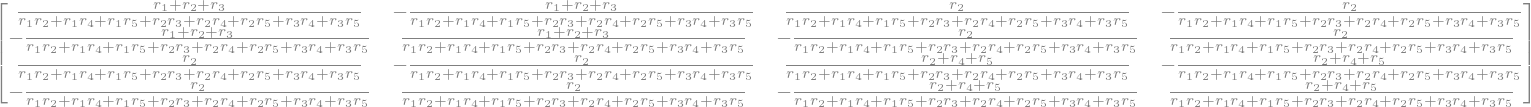

In [20]:
stoich_matrix_1 = Matrix( [[-1,1,0], [1,-1,-1], [0,0,1], [-1,0,-1], [0,1,0]])
num_internal_species_1 = 3
labels_1 = {0: 'Ea', 1: 'EaS', 2: 'EaS2', 3: 'S', 4: 'Na'}
species_names1 = ["Ea", "EaS", "EaS2", "S", "Na"]

stoich_matrix_2 = Matrix([[-1, 0, 1, 0, 0], # first row of internal
                           [1, -1, 0, -1, 0], 
                           [0, 1, -1, 0, 1], 
                           [0, 0, 0, 1, -1],
                             [0, 0, 0, -1, 0], # first row external 
                             [0, 0, 0, 0, 1],
                             [-1, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0]])

num_internal_species_2 = 4
labels_2 = {0: 'Eb', 1: 'EbF', 2: 'EbW', 3: 'Eb*', 4: 'Na', 5: 'Nb', 6: 'F', 7: 'W'}
species_names2 = ["Eb", "EbF", "EbW", "Eb*", "Na", "Nb", "F", "W"]

mod1 = ModuleProperties(stoich_matrix_1, num_internal_species_1, labels_1, species_names1)
mod2 = ModuleProperties(stoich_matrix_2, num_internal_species_2, labels_2, species_names2)
mod2.calculate_physical_conductance_matrix()

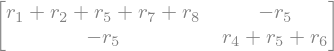

In [21]:
mod3 = CombiningModules(mod1, mod2)
mod3._assemble_mod3_resistance()